In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
!pip install pyspark
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d001f49c04e94952f3eef1084ca11e0d86c56da74910f9f7cfa15b498910d87c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.append(" ")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from pyspark.sql import SparkSession
from functools import reduce
# init SparkSession
spark = SparkSession.builder.appName("BDM Final").getOrCreate()

# read the csv file
base_path = "/content/drive/MyDrive/巨量資料/BDM_Final/archive-2/"

file_list = [
    "Covid-19 Twitter Dataset (Apr-Jun 2020).csv",
    "Covid-19 Twitter Dataset (Apr-Jun 2021).csv",
    "Covid-19 Twitter Dataset (Aug-Sep 2020).csv"
]

data_frames = []


for file_name in file_list:
    file_path = base_path + file_name
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    data_frames.append(df)

combined_df = reduce(lambda df1, df2: df1.union(df2), data_frames)

In [ ]:
from pyspark.sql.functions import udf, col

# 查看 distinct 的 sentiment 值
none_sentiments = combined_df.select("sentiment").distinct()

# 過濾出不是 'pos'、'neu'、'neg' 的資料
none_sentiments_df = none_sentiments.filter(
    (col("sentiment") != "pos") & (col("sentiment") != "neu") & (col("sentiment") != "neg")
)

# 顯示表格
none_sentiments_df.show(truncate=False)

+---------+
|sentiment|
+---------+
|0.151    |
|0.216    |
|0.157    |
|1.0      |
|0.147    |
|0.762    |
|0.671    |
|0.358    |
|0.272    |
|0.595    |
|0.647    |
|0.621    |
|0.341    |
|0.577    |
|0.763    |
|0.391    |
|0.641    |
|0.506    |
|0.566    |
|0.523    |
+---------+
only showing top 20 rows



In [ ]:
# Broadcast stopwords to all worker nodes
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

broadcast_stopwords = spark.sparkContext.broadcast(stopwords)

def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Check if sen is None
    if sen is None:
        return ""

    sentence = sen.lower()

    # Remove HTML tags
    sentence = remove_tags(sentence)

    # Remove punctuation and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Split sentence into words
    words = sentence.split()

    # Remove stopwords using the broadcasted list
    filtered_words = [word for word in words if word not in broadcast_stopwords.value]

    # Join words back into a sentence with spaces
    result_sentence = ' '.join(filtered_words)

    return result_sentence

# Define UDFs
remove_tags_udf = udf(remove_tags, StringType())
preprocess_text_udf = udf(preprocess_text, StringType())

# Sample DataFrame
sample_df = combined_df.select("clean_tweet").limit(20)

# Apply UDFs to create a new column
processed_df = sample_df.withColumn("clean_tweet_processed", preprocess_text_udf("clean_tweet"))

# Show the processed DataFrame
processed_df.show(truncate=False)

+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|clean_tweet                                                                          |clean_tweet_processed                                                                |
+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|call leader help protect refuge covid19 provid qualiti health care                   |call leader help protect refuge covid provid qualiti health care                     |
|ogun state support cbn nirsal covid19 target credit facil tcf                        |ogun state support cbn nirsal covid target credit facil tcf                          |
|polic offici base namahadi polic station busi drink liquor certain tavern whilst duti|polic offici base namahadi polic station bu

In [ ]:
# doing the preprocessing to the whole clean tweet
# and keep the create_at, favorite_count, retweet_count, hashtags, user_mentions these columns
# clean_tweet_processed is the clean_tweet after preprocessing
# after this, we will used "used_df" to analysis the things we want

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

spark = SparkSession.builder.appName("used df").getOrCreate()

# change the function to udf type
remove_tags_udf = udf(remove_tags, StringType())
preprocess_text_udf = udf(preprocess_text, StringType())

# deal with the none situation
clean_tweet_processed_udf = udf(lambda text: preprocess_text(remove_tags(text)) if text else "", StringType())


# preprocessing the clean_tweet column, and rebuild the data frame what we need
used_df = combined_df.withColumn("clean_tweet_processed", clean_tweet_processed_udf("clean_tweet")) \
                    .select("created_at", "favorite_count", "retweet_count", "hashtags", "user_mentions", "clean_tweet_processed")

# show the outcome to check
used_df.show(truncate=False)

+----------+--------------+-------------+---------------------------+----------------------------------------------------------------------+--------------------------+-------------------------------------------------------------------------------------+---------+
|created_at|favorite_count|retweet_count|place                      |hashtags                                                              |user_mentions             |clean_tweet_processed                                                                |sentiment|
+----------+--------------+-------------+---------------------------+----------------------------------------------------------------------+--------------------------+-------------------------------------------------------------------------------------+---------+
|2020-04-19|0.0           |31.0         |Jakarta Capital Region     |NULL                                                                  |GlblCtzn, priyankachopra  |call leader help protect refuge covid pro

In [ ]:
# 先整理出需要的資料欄位

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

spark = SparkSession.builder.appName("used df").getOrCreate()

# change the function to udf type
# remove_tags_udf = udf(remove_tags, StringType())
# preprocess_text_udf = udf(preprocess_text, StringType())

# deal with the none situation
clean_tweet_processed_udf = udf(lambda text: preprocess_text(remove_tags(text)) if text else "", StringType())


# preprocessing the clean_tweet column, and rebuild the data frame what we need
model_used_df = combined_df.withColumn("clean_tweet_processed", clean_tweet_processed_udf("clean_tweet")) \
                    .select("created_at", "clean_tweet_processed", "sentiment")

# show the outcome to check
model_used_df.show(truncate=False)

+----------+-------------------------------------------------------------------------------------+---------+
|created_at|clean_tweet_processed                                                                |sentiment|
+----------+-------------------------------------------------------------------------------------+---------+
|2020-04-19|call leader help protect refuge covid provid qualiti health care                     |pos      |
|2020-04-19|ogun state support cbn nirsal covid target credit facil tcf                          |pos      |
|2020-04-19|polic offici base namahadi polic station busi drink liquor certain tavern whilst duti|pos      |
|2020-04-19|                                                                                     |NULL     |
|en        |                                                                                     |NULL     |
|2020-04-19|condol famili surviv                                                                 |neu      |
|2020-04-19|receiv 

In [ ]:
# 過濾掉sentiment為空的狀況
filtered_model_used_df = model_used_df.filter(model_used_df["sentiment"].isNotNull())
filtered_model_used_df.show(truncate=False)

+----------+-------------------------------------------------------------------------------------+---------+
|created_at|clean_tweet_processed                                                                |sentiment|
+----------+-------------------------------------------------------------------------------------+---------+
|2020-04-19|call leader help protect refuge covid provid qualiti health care                     |pos      |
|2020-04-19|ogun state support cbn nirsal covid target credit facil tcf                          |pos      |
|2020-04-19|polic offici base namahadi polic station busi drink liquor certain tavern whilst duti|pos      |
|2020-04-19|condol famili surviv                                                                 |neu      |
|2020-04-19|receiv text year old son work covid patient equat quarantin com                      |neu      |
|2020-04-19|taiwan vice presid chen chien jen countri fight covid                                |neg      |
|2020-04-19|break n

In [ ]:
from pyspark.sql.functions import when, col

# 選擇 sentiment 欄位中不是 pos, neu, neg 的資料
other_sentiments_df = filtered_model_used_df.filter(~filtered_model_used_df['sentiment'].isin(['pos', 'neu', 'neg']))

# 將 'sentiment' 列轉換為浮點數型態
other_sentiments_df = other_sentiments_df.withColumn('sentiment', other_sentiments_df['sentiment'].cast('float'))

# 從 filtered_model_used_df 中刪除 other_sentiments_df 的資料
filtered_model_used_df = filtered_model_used_df.join(other_sentiments_df, on='sentiment', how='left_anti')

# 對 sentiment 欄位進行轉換
other_sentiments_df = other_sentiments_df.withColumn(
    'sentiment',
    when(other_sentiments_df['sentiment'] > 0.5, 'pos')
    .when(other_sentiments_df['sentiment'] == 0.5, 'neu')
    .otherwise('neg')
)

# 如果需要，將 other_sentiments_df 加回 filtered_model_used_df
filtered_model_used_df = filtered_model_used_df.unionByName(other_sentiments_df)

filtered_model_used_df = filtered_model_used_df.select(
    'created_at',
    'clean_tweet_processed',
    'sentiment',
)

# 顯示other_sentiments_df結果
other_sentiments_df.show()

# 顯示結果
filtered_model_used_df.show()

+----------+---------------------+---------+
|created_at|clean_tweet_processed|sentiment|
+----------+---------------------+---------+
|2020-04-19|                     |      neg|
|2020-04-19|            wagsphoto|      pos|
|2020-04-22|              buffalo|      neg|
|2020-04-22|                     |      neg|
|2020-04-22|             huffpost|      pos|
|2020-04-22|                     |      neg|
|2020-04-22| cbsnews keishabot...|      pos|
|2020-04-22|     montreal canadia|      neg|
|2020-04-22|              ireland|      neg|
|2020-04-22|                     |      pos|
|2020-04-22|                  usa|      neg|
|2020-04-22|   greater chicago il|      neg|
|2020-04-22|             new conn|      neg|
|2020-04-22|            albany ny|      neg|
|2020-04-22| rarely read priva...|      neg|
|2020-04-22|            lititz pa|      neg|
|2020-04-22|                     |      neg|
|2020-04-22|              offices|      neg|
|2020-04-22|        winchester va|      neg|
|2020-04-2

In [ ]:
from pyspark.sql.functions import when

# 定義轉換條件
sentiment_mapping = {
    'pos': 2,
    'neu': 1,
    'neg': 0
}

# 使用 withColumn 進行轉換
transformed_model_used_df = filtered_model_used_df.withColumn(
    'sentiment',
    when(filtered_model_used_df['sentiment'] == 'pos', sentiment_mapping['pos'])
    .when(filtered_model_used_df['sentiment'] == 'neu', sentiment_mapping['neu'])
    .when(filtered_model_used_df['sentiment'] == 'neg', sentiment_mapping['neg'])
)

# 顯示轉換後的 DataFrame
transformed_model_used_df.show()

+----------+---------------------+---------+
|created_at|clean_tweet_processed|sentiment|
+----------+---------------------+---------+
|2020-04-19| call leader help ...|        2|
|2020-04-19| ogun state suppor...|        2|
|2020-04-19| polic offici base...|        2|
|2020-04-19| condol famili surviv|        1|
|2020-04-19| receiv text year ...|        1|
|2020-04-19| taiwan vice presi...|        0|
|2020-04-19| break new york wo...|        0|
|2020-04-19| horribl tragedi n...|        1|
|2020-04-19| covid cure sooner...|        1|
|2020-04-19| januari nd total ...|        1|
|2020-04-19| covid attack almo...|        0|
|2020-04-19| prevent key know ...|        2|
|2020-04-19| break jigawa reco...|        1|
|2020-04-19| wallac pelosi als...|        0|
|2020-04-19| iphrc condemn unr...|        0|
|2020-04-19| tail leg open sta...|        1|
|2020-04-19| offic say speak m...|        1|
|2020-04-19| covid alberta doc...|        0|
|2020-04-19| cours still right...|        1|
|2020-04-1

In [ ]:
# 捨棄 sentiment 欄位為 NULL 的資料
model_final_used_df = transformed_model_used_df.filter(col('sentiment').isNotNull())

# 顯示結果
model_final_used_df.show()

+----------+---------------------+---------+
|created_at|clean_tweet_processed|sentiment|
+----------+---------------------+---------+
|2020-04-19| call leader help ...|        2|
|2020-04-19| ogun state suppor...|        2|
|2020-04-19| polic offici base...|        2|
|2020-04-19| condol famili surviv|        1|
|2020-04-19| receiv text year ...|        1|
|2020-04-19| taiwan vice presi...|        0|
|2020-04-19| break new york wo...|        0|
|2020-04-19| horribl tragedi n...|        1|
|2020-04-19| covid cure sooner...|        1|
|2020-04-19| januari nd total ...|        1|
|2020-04-19| covid attack almo...|        0|
|2020-04-19| prevent key know ...|        2|
|2020-04-19| break jigawa reco...|        1|
|2020-04-19| wallac pelosi als...|        0|
|2020-04-19| iphrc condemn unr...|        0|
|2020-04-19| tail leg open sta...|        1|
|2020-04-19| offic say speak m...|        1|
|2020-04-19| covid alberta doc...|        0|
|2020-04-19| cours still right...|        1|
|2020-04-1

In [ ]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline

# 創建 Tokenizer 實例，將文本分割成單詞
tokenizer = Tokenizer(inputCol="clean_tweet_processed", outputCol="words")

# 創建 CountVectorizer 實例，將單詞轉換為詞頻特徵
vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=1000, minDF=5)

# 建立情緒分析 Pipeline
pipeline = Pipeline(stages=[tokenizer, vectorizer])


# 創建 Tokenizer 實例，將文本分割成單詞
tokenizer = Tokenizer(inputCol="clean_tweet_processed", outputCol="words")

# 創建 CountVectorizer 實例，將單詞轉換為詞頻特徵
vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=1000, minDF=5)

# 建立 VectorAssembler 實例，將特徵列和標籤列合併為一個特徵向量列
assembler = VectorAssembler(inputCols=["features"], outputCol="feature_vector")

# 建立情緒分析 Pipeline
pipeline = Pipeline(stages=[tokenizer, vectorizer, assembler])

# 使用 Pipeline 擬合和轉換資料
model = pipeline.fit(model_final_used_df)
result = model.transform(model_final_used_df)

# 顯示轉換結果
result.select("created_at", "clean_tweet_processed", "feature_vector", "sentiment").show(truncate=False)

+----------+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+---------+
|created_at|clean_tweet_processed                                                                |feature_vector                                                                       |sentiment|
+----------+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+---------+
|2020-04-19|call leader help protect refuge covid provid qualiti health care                     |(1000,[0,8,19,46,57,103,107,218],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                  |2        |
|2020-04-19|ogun state support cbn nirsal covid target credit facil tcf                          |(1000,[0,16,41,510,937],[1.0,1.0,1.0,1.0,1.0])                                       |2        |
|2020-04-19|polic offici 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 获取 features_tensor 和 sentiment_tensor
features_tensor = torch.tensor(result.select("feature_vector").collect(), dtype=torch.float32)
sentiment_tensor = torch.tensor(result.select("sentiment").collect(), dtype=torch.long)

In [ ]:
from torch.utils.data import random_split

# 合并 features_tensor 和 sentiment_tensor 到一个 TensorDataset
dataset = TensorDataset(features_tensor, sentiment_tensor)

# 定义训练集和测试集的大小
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# 利用 random_split 进行分割
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建 DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### CNN

In [ ]:
# 假设 features_tensor 是从 PySpark DataFrame 中提取的特征张量
# sentiment_tensor 是 sentiment 列的整数形式的张量
# 请确保维度匹配

import torch.nn.functional as F

# simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 499, 3)  # 3 is the number of categories

    def forward(self, x):
        # Reshape input
        x = x.view(x.size(0), 1, -1)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


# initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# model training
epochs = 10
for epoch in range(epochs):
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        # Add one dimension to the second dimension, in order to meet the requirements of the convolutional layer
        outputs = model(inputs.unsqueeze(1))
        # turn the labels into long type
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()


In [ ]:
import numpy as np

model.eval()  # 将模型切换为评估模式

predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 将列表转换为 NumPy 数组
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# 检查前几个样本的预测结果和真实标签
print("Predicted Labels:", predicted_labels[:10])
print("True Labels:", true_labels[:10])

Predicted Labels: [0 1 1 0 1 2 1 1 0 0]
True Labels: [[0]
 [1]
 [1]
 [0]
 [1]
 [2]
 [1]
 [1]
 [0]
 [0]]


In [ ]:
from sklearn.metrics import accuracy_score

# 计算准确度
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 86.12%


#### LSTM

In [ ]:
# simple LSTM model

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # need to let the shape of x be (batch_size * sequence_length, input_size)
        x = x.view(x.size(0), -1, x.size(-1))

        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1, :, :])
        return out


# initialize the model, loss function, and optimizer
input_size = 1000
hidden_size = 64
output_size = 3
model = SimpleLSTM(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# model training
epochs = 10
for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print the training loss
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {running_loss / len(train_dataloader)}")

Epoch 1/10, Training Loss: 0.47494390922043894
Epoch 2/10, Training Loss: 0.4158572810115784
Epoch 3/10, Training Loss: 0.4008712821358431
Epoch 4/10, Training Loss: 0.3840216678253005
Epoch 5/10, Training Loss: 0.36546466442892855
Epoch 6/10, Training Loss: 0.3434408057669635
Epoch 7/10, Training Loss: 0.31960032704359587
Epoch 8/10, Training Loss: 0.2950940129356772
Epoch 9/10, Training Loss: 0.27177009155458887
Epoch 10/10, Training Loss: 0.2500467841174545


In [ ]:
model.eval()  # 將模型切換為評估模式

lstm_predicted_labels = []
lstm_true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        print(inputs.shape)  # 添加此行

        # 確保輸入的形狀是 (batch_size, sequence_length, input_size)
        inputs = inputs.unsqueeze(1)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        lstm_predicted_labels.extend(predicted.cpu().numpy())
        lstm_true_labels.extend(labels.cpu().numpy())

# 將列表轉換為 NumPy 數組
lstm_predicted_labels = np.array(lstm_predicted_labels)
lstm_true_labels = np.array(lstm_true_labels)

# 檢查前幾個樣本的預測結果和真實標籤
print("LSTM Predicted Labels:", lstm_predicted_labels[:10])
print("LSTM True Labels:", lstm_true_labels[:10])

torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([64, 1, 1000])
torch.Size([

In [ ]:
# 计算准确度
lstm_accuracy = accuracy_score(lstm_true_labels, lstm_predicted_labels)

print(f"LSTM Test Accuracy: {lstm_accuracy * 100:.2f}%")

LSTM Test Accuracy: 85.42%


#### CNN+LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

# 假设你的 feature_vector 的维度是 feature_dim
feature_dim = features_tensor.size(1)

# CNN 模型
class CNNModel(nn.Module):
    def __init__(self, feature_dim, num_filters, kernel_size):
        super(CNNModel, self).__init__()
        self.cnn_layer = nn.Conv1d(in_channels=64, out_channels=num_filters, kernel_size=kernel_size, padding="same")
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        x = x.squeeze(2).squeeze(1)
        x = self.cnn_layer(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        return x


# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, num_filters, lstm_hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm_layer = nn.LSTM(input_size=num_filters, hidden_size=lstm_hidden_size, batch_first=True, bidirectional=True)

    def forward(self, x):
        _, (h_n, _) = self.lstm_layer(x)

        # 檢查 h_n 的形狀
        print("Shape of h_n:", h_n.shape)

        return h_n

# 模型組合
class CombinedModel(nn.Module):
    def __init__(self, feature_dim, num_filters, kernel_size, lstm_hidden_size, output_size):
        super(CombinedModel, self).__init__()
        self.cnn = CNNModel(feature_dim, num_filters, kernel_size)
        self.lstm = LSTMModel(num_filters, lstm_hidden_size)
        # 修改這裡的輸入和輸出大小
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear) or isinstance(m, nn.LSTM):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        print("Input Shape in CombinedModel forward:", x.shape)
        x = self.cnn(x.unsqueeze(1))
        print("Output Shape after CNN:", x.shape)
        x = self.lstm(x)
        print("Output Shape after LSTM:", x.shape)
        x = self.fc(x)  # 不要使用 softmax
        print("Output Shape after FC:", x.shape)
        return x


# 定義模型超參數
num_filters = 64
kernel_size = 5
lstm_hidden_size = 128
output_size = 3

# 創建模型
model = CombinedModel(feature_dim, num_filters, kernel_size, lstm_hidden_size, output_size)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        # 添加下面这行代码
        print("Input Shape:", inputs.shape)

        outputs = model(inputs)
        print("Output Shape:", outputs.shape)
        print("Labels Shape before squeeze:", labels.shape)

        # 去除标签中的单维度
        labels = labels.view(-1)
        print("Labels Shape after squeeze:", labels.shape)

        print("Output Values:\n", outputs)
        print("Labels Values:\n", labels)

        # 计算损失，使用 F.cross_entropy
        loss = F.cross_entropy(outputs, labels, ignore_index=-100)
        loss.backward()

        # 裁剪梯度
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {running_loss / len(train_dataloader)}")


Input Shape: torch.Size([64, 1, 1000])
Input Shape in CombinedModel forward: torch.Size([64, 1, 1000])
Output Shape after CNN: torch.Size([64, 500])
Shape of h_n: torch.Size([2, 128])
Output Shape after LSTM: torch.Size([2, 128])
Output Shape after FC: torch.Size([2, 3])
Output Shape: torch.Size([2, 3])
Labels Shape before squeeze: torch.Size([64, 1])
Labels Shape after squeeze: torch.Size([64])
Output Values:
 tensor([[nan, nan, nan],
        [nan, nan, nan]], grad_fn=<AddmmBackward0>)
Labels Values:
 tensor([2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0,
        1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2,
        1, 1, 0, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 0, 1, 1])


ValueError: ignored

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, cnn_input_size, lstm_input_size, hidden_size, output_size):
        super(CombinedModel, self).__init__()

        # CNN layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc_cnn = nn.Linear(64 * cnn_input_size, lstm_input_size)

        # LSTM layer
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, batch_first=True)

        # Fully connected layer for sentiment prediction
        self.fc_final = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # CNN layer
        x_cnn = x.view(x.size(0), 1, -1)
        x_cnn = self.pool(F.relu(self.conv1(x_cnn)))
        x_cnn = x_cnn.view(x_cnn.size(0), -1)
        x_cnn = F.relu(self.fc_cnn(x_cnn))

        # LSTM layer
        x_lstm, _ = self.lstm(x_cnn.unsqueeze(1))

        # Fully connected layer for sentiment prediction
        x_final = self.fc_final(x_lstm[:, -1, :])

        return x_final

# Initialize the model, criterion, and optimizer
cnn_input_size = 499  # Change this based on the output size of your CNN layer
lstm_input_size = 64  # Change this based on the hidden size of your LSTM layer
hidden_size = 64      # Change this based on your requirements
output_size = 3       # Number of sentiment classes

combined_model = CombinedModel(cnn_input_size, lstm_input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# Train the combined model
epochs = 10
for epoch in range(epochs):
    # Set the model to training mode
    combined_model.train()

    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = combined_model(inputs)
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the training loss
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {running_loss / len(train_dataloader)}")

Epoch 1/10, Training Loss: 0.5252266864529536
Epoch 2/10, Training Loss: 0.4093809833687432
Epoch 3/10, Training Loss: 0.397923984642595
Epoch 4/10, Training Loss: 0.3890251283707399
Epoch 5/10, Training Loss: 0.3811074899755894
Epoch 6/10, Training Loss: 0.3733362336626996
Epoch 7/10, Training Loss: 0.36588812790951264
Epoch 8/10, Training Loss: 0.3599150890073219
Epoch 9/10, Training Loss: 0.3532913015212932
Epoch 10/10, Training Loss: 0.3474617716909371


In [ ]:
import numpy as np
combined_model.eval()  # 將模型切換為評估模式

com_predicted_labels = []
com_true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        # print(inputs.shape)  # 添加此行

        # 確保輸入的形狀是 (batch_size, sequence_length, input_size)
        inputs = inputs.unsqueeze(1)

        outputs = combined_model(inputs)
        _, predicted = torch.max(outputs, 1)

        com_predicted_labels.extend(predicted.cpu().numpy())
        com_true_labels.extend(labels.cpu().numpy())

# 將列表轉換為 NumPy 數組
com_predicted_labels = np.array(com_predicted_labels)
com_true_labels = np.array(com_true_labels)

# 檢查前幾個樣本的預測結果和真實標籤
print("COM Predicted Labels:", com_predicted_labels[:10])
print("COM True Labels:", com_true_labels[:10])

COM Predicted Labels: [0 2 2 2 2 1 1 2 0 2]
COM True Labels: [[0]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [0]
 [2]]


In [ ]:
from sklearn.metrics import accuracy_score

# count accuracy
COM_accuracy = accuracy_score(com_true_labels, com_predicted_labels)

print(f"Combined Model Test Accuracy: {COM_accuracy * 100:.2f}%")

Combined Model Test Accuracy: 86.46%


#### 關於train data 和test data 在epoches中的準確度

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, cnn_input_size, lstm_input_size, hidden_size, output_size):
        super(CombinedModel, self).__init__()

        # CNN layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc_cnn = nn.Linear(64 * cnn_input_size, lstm_input_size)

        # LSTM layer
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, batch_first=True)

        # Fully connected layer for sentiment prediction
        self.fc_final = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # CNN layer
        x_cnn = x.view(x.size(0), 1, -1)
        x_cnn = self.pool(F.relu(self.conv1(x_cnn)))
        x_cnn = x_cnn.view(x_cnn.size(0), -1)
        x_cnn = F.relu(self.fc_cnn(x_cnn))

        # LSTM layer
        x_lstm, _ = self.lstm(x_cnn.unsqueeze(1))

        # Fully connected layer for sentiment prediction
        x_final = self.fc_final(x_lstm[:, -1, :])

        return x_final

Epoch 1/10, Training Loss: 0.5099588415484008, Training Accuracy: 0.8111027806658189
Epoch 1/10, Testing Loss: 0.42529473470334533, Testing Accuracy: 0.8615027752464585
Epoch 2/10, Training Loss: 0.40994624929784496, Training Accuracy: 0.8664137156869649
Epoch 2/10, Testing Loss: 0.4152691324588732, Testing Accuracy: 0.865363267334935
Epoch 3/10, Training Loss: 0.39856781273598446, Training Accuracy: 0.8684309721353509
Epoch 3/10, Testing Loss: 0.4128801986354135, Testing Accuracy: 0.8656946400463922
Epoch 4/10, Training Loss: 0.3894146504924748, Training Accuracy: 0.8698973146050195
Epoch 4/10, Testing Loss: 0.41243883938986364, Testing Accuracy: 0.865363267334935
Epoch 5/10, Training Loss: 0.3802846138400865, Training Accuracy: 0.8717613092698526
Epoch 5/10, Testing Loss: 0.41430620045669503, Testing Accuracy: 0.8649159141744678
Epoch 6/10, Training Loss: 0.3728595724630002, Training Accuracy: 0.8729087015413165
Epoch 6/10, Testing Loss: 0.41775618947379417, Testing Accuracy: 0.86377

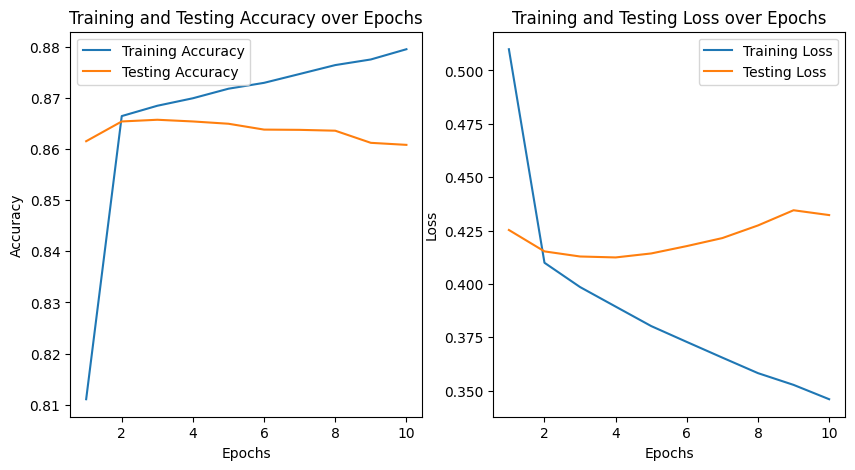

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initialize the model, criterion, and optimizer
cnn_input_size = 499  # Change this based on the output size of your CNN layer
lstm_input_size = 64   # Change this based on the hidden size of your LSTM layer
hidden_size = 64       # Change this based on your requirements
output_size = 3        # Number of sentiment classes

combined_model = CombinedModel(cnn_input_size, lstm_input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# Lists to store training and testing history
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

# Train the combined model
epochs = 10
for epoch in range(epochs):
    # Set the model to training mode
    combined_model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0


    ### about training data

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = combined_model(inputs)
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.squeeze()).sum().item()
        total_samples += labels.size(0)

    # Calculate training accuracy for the epoch
    train_accuracy = correct_predictions / total_samples

    # Save training history
    train_loss_history.append(running_loss / len(train_dataloader))
    train_accuracy_history.append(train_accuracy)

    # Print the training loss and accuracy
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss_history[-1]}, Training Accuracy: {train_accuracy}")



    #### about testing data
    # Set the model to evaluation mode
    combined_model.eval()

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = combined_model(inputs)
            loss = criterion(outputs, labels.squeeze().long())

            running_loss += loss.item()

            # Calculate testing accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels.squeeze()).sum().item()
            total_samples += labels.size(0)

    # Calculate testing accuracy for the epoch
    test_accuracy = correct_predictions / total_samples

    # Save testing history
    test_loss_history.append(running_loss / len(test_dataloader))
    test_accuracy_history.append(test_accuracy)

    # Print the testing loss and accuracy
    print(f"Epoch {epoch + 1}/{epochs}, Testing Loss: {test_loss_history[-1]}, Testing Accuracy: {test_accuracy}")


#### picture
# Plot training and testing history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_history, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss_history, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()

plt.show()

Epoch 1/2, Training Loss: 0.5240650157807772, Training Accuracy: 0.8031497367625312
Epoch 1/2, Testing Loss: 0.42082008443993785, Testing Accuracy: 0.863457874244056
Epoch 2/2, Training Loss: 0.40904666766378184, Training Accuracy: 0.8669107809309203
Epoch 2/2, Testing Loss: 0.41110093801645403, Testing Accuracy: 0.8652141496147793


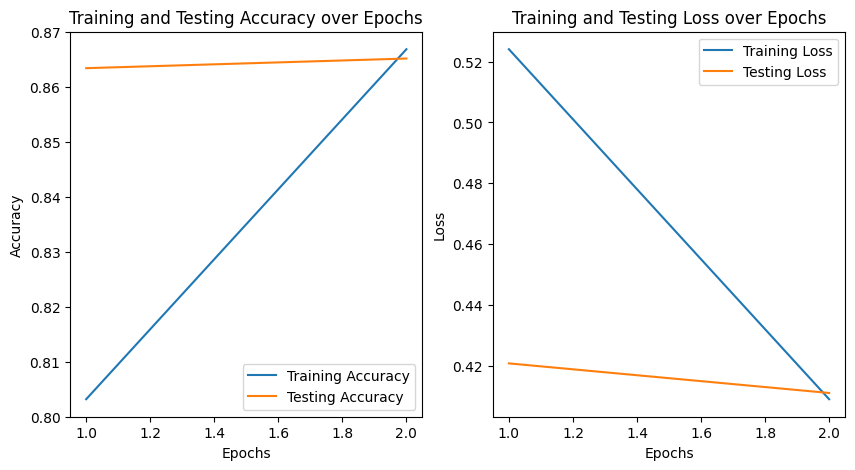

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initialize the model, criterion, and optimizer
cnn_input_size = 499  # Change this based on the output size of your CNN layer
lstm_input_size = 64   # Change this based on the hidden size of your LSTM layer
hidden_size = 64       # Change this based on your requirements
output_size = 3        # Number of sentiment classes

combined_model = CombinedModel(cnn_input_size, lstm_input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# Lists to store training and testing history
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

# Train the combined model
epochs = 2
for epoch in range(epochs):
    # Set the model to training mode
    combined_model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0


    ### about training data

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = combined_model(inputs)
        loss = criterion(outputs, labels.squeeze().long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.squeeze()).sum().item()
        total_samples += labels.size(0)

    # Calculate training accuracy for the epoch
    train_accuracy = correct_predictions / total_samples

    # Save training history
    train_loss_history.append(running_loss / len(train_dataloader))
    train_accuracy_history.append(train_accuracy)

    # Print the training loss and accuracy
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss_history[-1]}, Training Accuracy: {train_accuracy}")



    #### about testing data
    # Set the model to evaluation mode
    combined_model.eval()

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = combined_model(inputs)
            loss = criterion(outputs, labels.squeeze().long())

            running_loss += loss.item()

            # Calculate testing accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels.squeeze()).sum().item()
            total_samples += labels.size(0)

    # Calculate testing accuracy for the epoch
    test_accuracy = correct_predictions / total_samples

    # Save testing history
    test_loss_history.append(running_loss / len(test_dataloader))
    test_accuracy_history.append(test_accuracy)

    # Print the testing loss and accuracy
    print(f"Epoch {epoch + 1}/{epochs}, Testing Loss: {test_loss_history[-1]}, Testing Accuracy: {test_accuracy}")


#### picture
# Plot training and testing history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_history, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss_history, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()

plt.show()